In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import pickle
from itertools import compress
warnings.filterwarnings('ignore')
% matplotlib inline

In [2]:
from model_generator import *

### Generate df

In [3]:
paths_dict_band = json.load(open('inputs_json/paths_dict_band.json', 'r'))

In [4]:
band = generate_df(paths_dict_band, 'band', '2016')

In [5]:
df = band.return_completed_df()

In [6]:
name_list_24 = ['band']

In [7]:
feature_eng_df = band.return_df_feature_engineering(name_list_24)

In [8]:
band_mean_vol_aemet = pd.read_csv('aemet/band_mean_vol_pred_aemet.csv', encoding='latin1', index_col=0)

In [9]:
final_df = feature_eng_df.merge(band_mean_vol_aemet, how='left', left_index=True, right_index=True)

In [10]:
for feature in ['pred_band_mean_aemet', 'pred_band_vol_aemet']:
    final_df[feature].fillna(method='pad', inplace=True)

In [11]:
features_list = json.load(open('inputs_json/feature_list_band.json', 'r'))

In [12]:
len(features_list)

78

### Train model

In [13]:
lgbm_model_grouped = train_model(df=final_df, output='band', features_list=features_list,
                                n_folds=5, cv_type='group')

In [14]:
rf_model_grouped = train_model(df=final_df, output='band', features_list=features_list,
                                n_folds=5, cv_type='group')

In [15]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso
pipeline = LGBMRegressor(num_leaves=60, learning_rate=0.08, n_estimators=1000, seed=0)
pipeline_group = LGBMRegressor(num_leaves=40, learning_rate=0.05, n_estimators=700, seed=0)
rf_pipeline_group = make_pipeline(Imputer(strategy='median'),
                          RandomForestRegressor(n_estimators=80, max_depth=9, 
                                                max_features='sqrt', max_leaf_nodes=200, 
                                                n_jobs=-1, random_state=0, min_samples_split=80,
                                               min_samples_leaf=25))

In [16]:
lgbm_model_grouped.obtain_cv_score(pipeline_group)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 4.4339 +- 0.2501
Mean squared error: 43.6414 +- 12.3115


In [17]:
rf_model_grouped.obtain_cv_score(rf_pipeline_group)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 4.8478 +- 0.2187
Mean squared error: 51.7095 +- 12.5450


In [18]:
lgbm_model_grouped.obtain_train_test_error(pipeline_group)

Train MAE: 2.26675662627, Train MSE: 10.3248012922
Test MAE: 4.76994217274, Test MSE: 62.6649409936


In [19]:
rf_model_grouped.obtain_train_test_error(rf_pipeline_group)

Train MAE: 4.0649028767, Train MSE: 36.4795772328
Test MAE: 5.26308019263, Test MSE: 68.2220798909


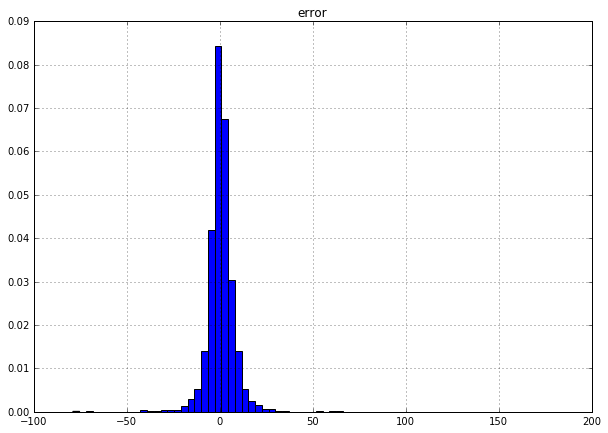

In [20]:
lgbm_model_grouped.plot_histogram_error()

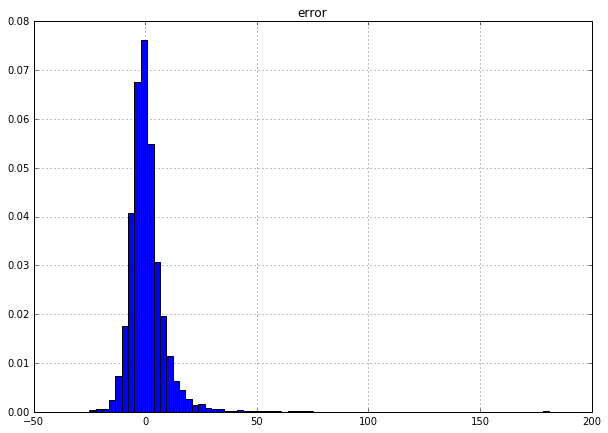

In [21]:
rf_model_grouped.plot_histogram_error()

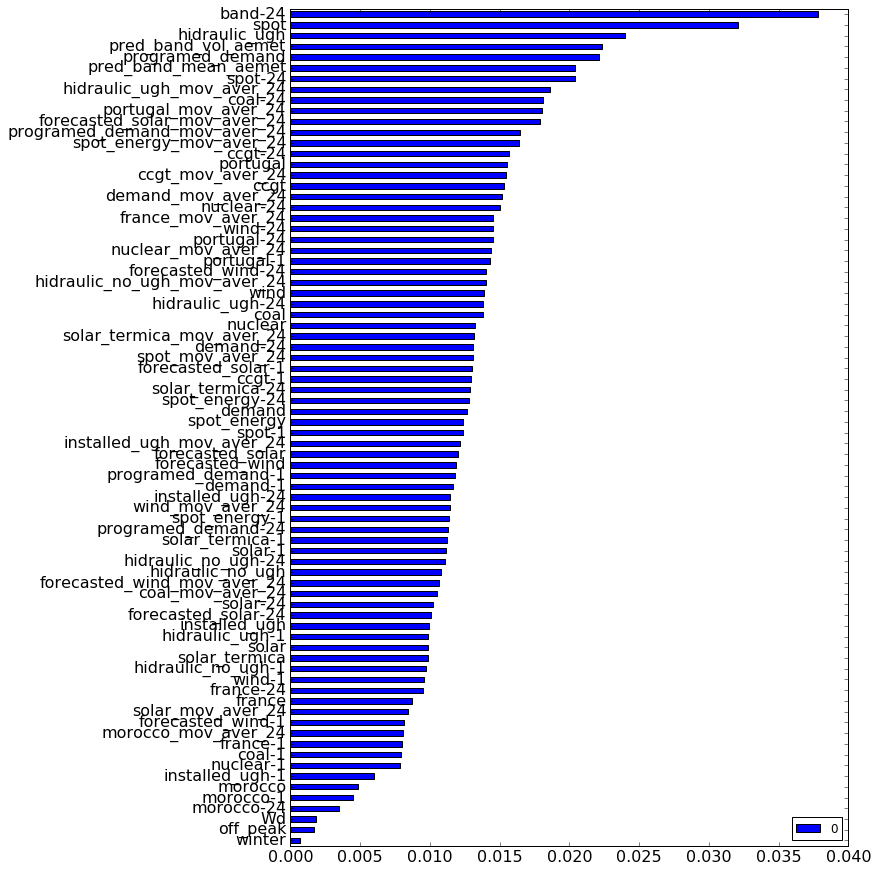

In [22]:
lgbm_model_grouped.get_feature_importance()

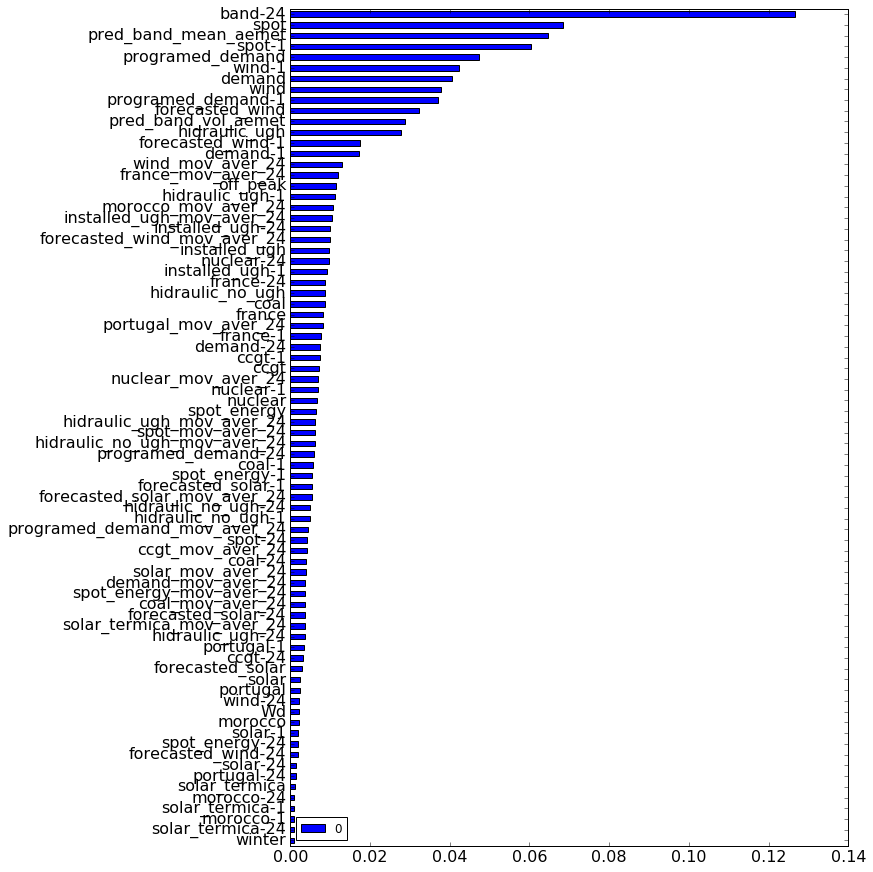

In [23]:
rf_model_grouped.get_feature_importance()

In [24]:
lgbm_metamodel = metamodel(features=features_list, pipeline=pipeline_group, n_folds=5, 
                           num_cv=1, cv_type='group',
                           metric={'mae':mean_absolute_error, 'mse':mean_squared_error})

In [25]:
date, oos_lgbm = lgbm_metamodel.get_oos_cv_predictions(x_train=final_df.reset_index(),
                                                      y_train=final_df['band'],
                                                      index_col='date_hour')

CV number:  1
Acting on fold 1 of 1
Acting on fold 2 of 1
Acting on fold 3 of 1
Acting on fold 4 of 1
Acting on fold 5 of 1
mae on 1 CV: 4.4415 +- 0.4565
mse on 1 CV: 46.1259 +- 19.4247


In [26]:
rf_metamodel = metamodel(features=features_list, pipeline=rf_pipeline_group, n_folds=5, 
                         num_cv=1, cv_type='group',
                         metric={'mae': mean_absolute_error, 'mse':mean_squared_error})

In [27]:
date, oos_rf = rf_metamodel.get_oos_cv_predictions(x_train=final_df.reset_index(),
                                                  y_train=final_df['band'],
                                                  index_col='date_hour')

CV number:  1
Acting on fold 1 of 1
Acting on fold 2 of 1
Acting on fold 3 of 1
Acting on fold 4 of 1
Acting on fold 5 of 1
mae on 1 CV: 4.8771 +- 0.5341
mse on 1 CV: 53.5055 +- 19.3652


In [28]:
stack_df = pd.DataFrame({'lgbm': oos_lgbm, 'rf': oos_rf, 'band': final_df['band']}, index=date)

In [29]:
pipeline_stack = make_pipeline(Imputer(strategy='median'), StandardScaler(), 
                               Ridge(alpha=1, random_state=0))

In [30]:
stack_df['hour'] = stack_df.index.hour
stack_df[pd.get_dummies(stack_df['hour'], drop_first=True).columns.tolist()] = pd.get_dummies(stack_df['hour'], drop_first=True)

In [31]:
features_stack_final = [ element for element in stack_df.columns.tolist() if element not in ['band', 'hour']]

In [32]:
stack_model = train_model(stack_df, 'band', features_stack_final, n_folds=5, cv_type='group')

In [33]:
stack_model.obtain_cv_score(pipeline_stack)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 4.2729 +- 0.3407
Mean squared error: 40.1991 +- 12.4015


In [34]:
stack_model.obtain_train_test_error(pipeline_stack)

Train MAE: 4.26569157099, Train MSE: 40.048705008
Test MAE: 4.66894904093, Test MSE: 57.5127097365


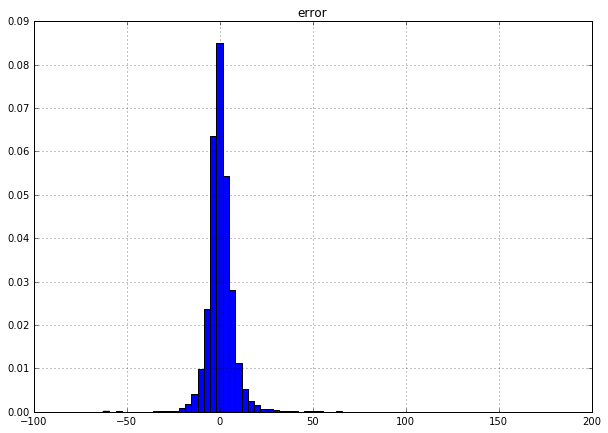

In [35]:
stack_model.plot_histogram_error()

In [36]:
stack_model.get_feature_importance()

                   0
intercept  19.306246
lgbm        6.975043
rf          3.180108
1           0.031858
2          -0.348117
3          -0.399989
4          -0.610890
5          -0.553768
6          -0.023655
7          -0.214749
8          -0.196305
9          -0.034713
10         -0.109509
11         -0.309064
12         -0.308053
13         -0.287033
14          0.020363
15          0.061165
16         -0.220712
17         -0.316949
18         -0.292333
19         -0.338072
20         -0.338421
21         -0.255709
22         -0.125961
23         -0.156123


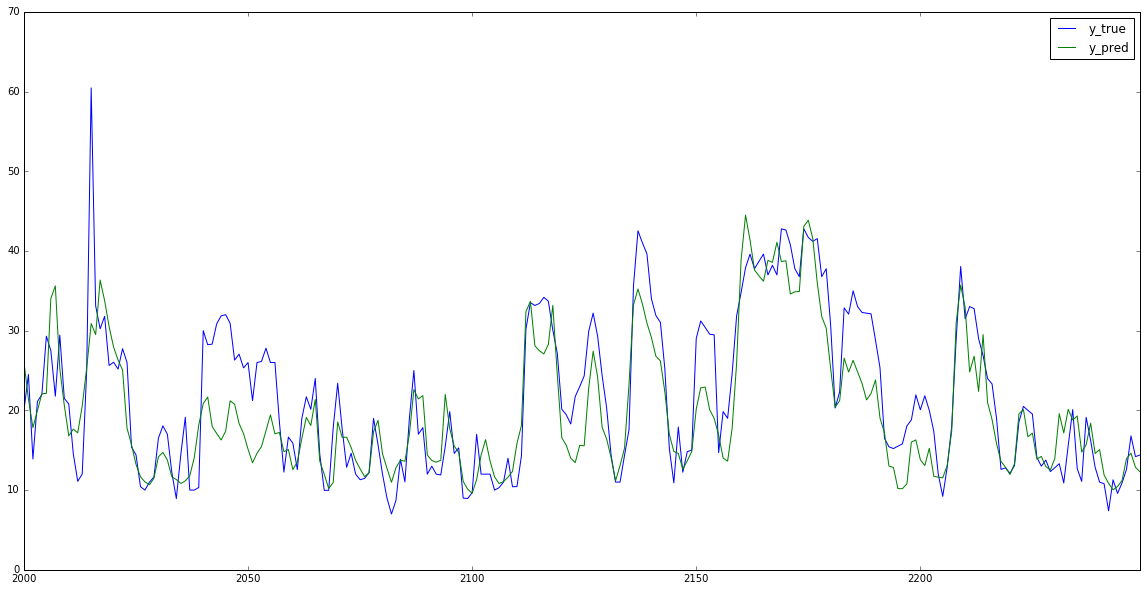

In [37]:
stack_model.errors_df[['y_true', 'y_pred']].iloc[2000:2250].plot(figsize=(20,10))

In [38]:
residuals_lgbm = lgbm_model_grouped.get_log_residuals()

In [39]:
residuals_rf = rf_model_grouped.get_log_residuals()

In [40]:
residuals_stack = stack_model.get_log_residuals()

### Export residuals and model

In [41]:
with open('models_p/pipeline_stack.p', 'wb') as f:
    pickle.dump(stack_model.pipeline, f)
    
with open('models_p/lgbm_band_group.p', 'wb') as f:
    pickle.dump(lgbm_model_grouped.pipeline, f)
    
with open('models_p/rf_model_grouped.p', 'wb') as f:
    pickle.dump(rf_model_grouped.pipeline, f)
    
with open('inputs_json/feature_list_band_stakc.json', 'w') as f:
    json.dump([str(element) for element in stack_model.features_list], f)

residuals_lgbm.to_json('inputs_json/residuals_band_lgbm_group.json', orient='index', date_format='iso')

residuals_rf.to_json('inputs_json/residuals_rf.json', orient='index', date_format='iso')
    
residuals_stack.to_json('inputs_json/residuals_stack.json',
                              orient='index', date_format='iso')